# Lab Deep Learning/ Recurrent Neural Networks/ in keras

## Training language model (Many-to-Many) and generating sequences (One-to-Many)

**Author: geoffroy.peeters@telecom-paris.fr**

For any remark or suggestion, please feel free to contact me.


## Objective:

- We will train a network to learn a language model and then use it to generate new sequences.

- Instead of training the language model on text-documents (as it is the case in most examples) we will train it to learn the language of the music of [Johann_Sebastian_Bach](https://en.wikipedia.org/wiki/Johann_Sebastian_Bach).
For this, we will learn how J. S. Bach's "Cello suite" have been composed.
Here is an example of a "Cello suite" [Link](https://www.youtube.com/watch?v=mGQLXRTl3Z0).

- Rather than analyzing the audio signal, we use a symbolic representation of the "Cello suite" through their [MIDI files](https://en.wikipedia.org/wiki/MIDI#MIDI_files).
  - A MIDI file encodes in a file, the set of musical notes, their duration, and intensity which have to be played by each instrument to "render" a musical piece. The "rendering" is usually operated by a MIDI synthesizer (such as VLC, QuickTime).

- We will first train a language model on the whole set of MIDI files of the "Cello suites". 
- We will then sample this language model to create a new MIDI file which will be a brand new "Cello suite" composed by the computer.

### Questions:

In the bottom part of this lab, you will have to answer a set of questions. Answers to those only necessitates a couple of sentences.

## Import packages

In [275]:
pip install pretty_midi

Note: you may need to restart the kernel to use updated packages.


In [276]:
import os
import pretty_midi
from scipy.io import wavfile 
import IPython

from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Flatten, Dropout, Activation
from keras import backend as K
from keras import Model

import matplotlib.pyplot as plt
import numpy as np
import glob

student = True

# Get the data

In [277]:
n_x = 79
max_T_x = 1000
sequence_length = 20
T_y_generated = 200

## Collect data to create the language model

We download the 36 MIDI files corresponding to the 36 "Cello suites" composed by J. S. Bach.

In [278]:
DIR = './'
import urllib.request
midiFile_l = ['cs1-2all.mid', 'cs5-1pre.mid', 'cs4-1pre.mid', 'cs3-5bou.mid', 'cs1-4sar.mid', 'cs2-5men.mid', 'cs3-3cou.mid', 'cs2-3cou.mid', 'cs1-6gig.mid', 'cs6-4sar.mid', 'cs4-5bou.mid', 'cs4-3cou.mid', 'cs5-3cou.mid', 'cs6-5gav.mid', 'cs6-6gig.mid', 'cs6-2all.mid', 'cs2-1pre.mid', 'cs3-1pre.mid', 'cs3-6gig.mid', 'cs2-6gig.mid', 'cs2-4sar.mid', 'cs3-4sar.mid', 'cs1-5men.mid', 'cs1-3cou.mid', 'cs6-1pre.mid', 'cs2-2all.mid', 'cs3-2all.mid', 'cs1-1pre.mid', 'cs5-2all.mid', 'cs4-2all.mid', 'cs5-5gav.mid', 'cs4-6gig.mid', 'cs5-6gig.mid', 'cs5-4sar.mid', 'cs4-4sar.mid', 'cs6-3cou.mid']
for midiFile in midiFile_l:
  #if os.path.isfile(DIR + midiFile) is None:
  urllib.request.urlretrieve ("http://www.jsbach.net/midi/" + midiFile, DIR + midiFile)
nbExample = len(midiFile_l)

midiFile_l = glob.glob(DIR + 'cs*.mid')
print(midiFile_l)

['./cs3-4sar.mid', './cs6-1pre.mid', './cs3-2all.mid', './cs4-2all.mid', './cs5-6gig.mid', './cs2-2all.mid', './cs1-3cou.mid', './cs4-4sar.mid', './cs4-3cou.mid', './cs5-2all.mid', './cs5-1pre.mid', './cs1-1pre.mid', './cs1-6gig.mid', './cs6-5gav.mid', './cs2-1pre.mid', './cs6-3cou.mid', './cs6-2all.mid', './cs4-6gig.mid', './cs2-4sar.mid', './cs5-5gav.mid', './cs3-1pre.mid', './cs4-1pre.mid', './cs6-6gig.mid', './cs5-3cou.mid', './cs2-3cou.mid', './cs1-4sar.mid', './cs6-4sar.mid', './cs5-4sar.mid', './cs1-5men.mid', './cs2-5men.mid', './cs3-3cou.mid', './cs2-6gig.mid', './cs4-5bou.mid', './cs3-6gig.mid', './cs1-2all.mid', './cs3-5bou.mid']


## Read and convert all MIDI files

In [279]:
# --- Read a single MIDI file
midi_data = pretty_midi.PrettyMIDI(midiFile_l[0])
# --- Display the note pitch, start, end and duration
for note in midi_data.instruments[0].notes:
    print('pitch: %d, start: %f, end: %f, duration: %f' % (note.pitch, note.start, note.end, note.end-note.start))

pitch: 60, start: 0.000000, end: 1.500000, duration: 1.500000
pitch: 60, start: 1.500000, end: 2.625000, duration: 1.125000
pitch: 57, start: 2.625000, end: 3.000000, duration: 0.375000
pitch: 59, start: 3.000000, end: 4.500000, duration: 1.500000
pitch: 58, start: 4.500000, end: 6.000000, duration: 1.500000
pitch: 58, start: 6.000000, end: 7.125000, duration: 1.125000
pitch: 55, start: 7.125000, end: 7.500000, duration: 0.375000
pitch: 57, start: 7.500000, end: 9.000000, duration: 1.500000
pitch: 50, start: 9.000000, end: 9.750000, duration: 0.750000
pitch: 52, start: 9.750000, end: 10.125000, duration: 0.375000
pitch: 53, start: 10.125000, end: 10.500000, duration: 0.375000
pitch: 53, start: 10.500000, end: 11.625000, duration: 1.125000
pitch: 50, start: 11.625000, end: 12.000000, duration: 0.375000
pitch: 52, start: 12.000000, end: 12.750000, duration: 0.750000
pitch: 53, start: 12.750000, end: 13.500000, duration: 0.750000
pitch: 48, start: 13.500000, end: 13.875000, duration: 0.37

We read all MIDI files and convert their content to one-hot-encoding matrix X_ohe of dimensions (T_x, n_x) where n_x is the number of possible musical notes.
The duration of the sequences T_x can vary from one sequence to the other.
 


In [280]:
# --- We truncate the duration of each example to the first T_x data

X_list = []

for midiFile in midiFile_l:
    # read the MIDI file
    midi_data = pretty_midi.PrettyMIDI(midiFile)
    note_l = [note.pitch for note in midi_data.instruments[0].notes]
    # convert to one-hot-encoding
    T_x = len(note_l)
    if T_x > max_T_x:
      T_x = max_T_x
    X_ohe = np.zeros((T_x, n_x))
    for t in range(T_x): 
      X_ohe[t, note_l[t]-1] = 1
    # add to the list  
    X_list.append(X_ohe)
    
print(len(X_list))
print(X_list[0].shape)
print(X_list[1].shape)
print(X_list[2].shape)

36
(196, 79)
(1000, 79)
(922, 79)


## Display the set of notes over time for a specific track 

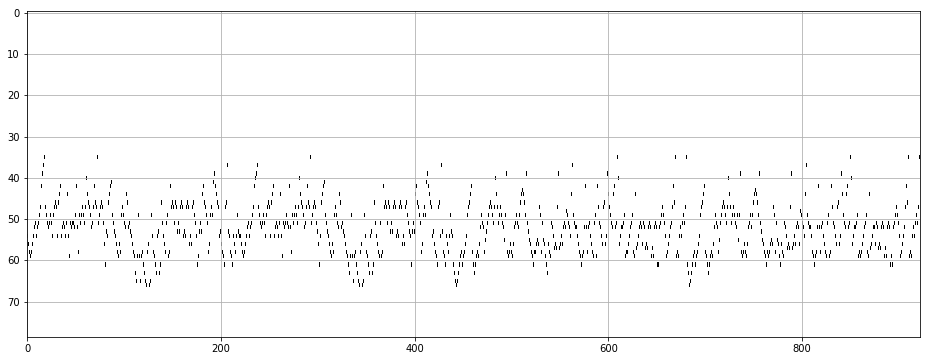

In [281]:
plt.figure(figsize=(16, 6))
plt.imshow(X_list[2].T, aspect='auto')
plt.set_cmap('gray_r')
plt.grid(True)

## Data conversion for the training of language model

For each example/sequence and each possible starting note in this example/sequence, we create two sequences
- an input sequence: 
  - which contains a sub-sequence of length ```sequence_length```;  this sub-sequence range from the note $t$ to the note $t+sequence\_length-1$
- an output sequence:
  - which contains the following note to be predicted, the one at position $t+sequence\_length$

The training is therefore performed by giving to the model a set of sequences as input and asking the network to predict each time the note that should come right after this sequence.

In [282]:
X_train_list = []
y_train_list = []

if student:
    # --- START CODE HERE (01)
    
    # iterate on the number or example
    for i in range (len(X_list)):
        
        # for each example, split into as many batch as possible with the sequence_lenght 
        for j in range (len(X_list[i]-1)):
            
             if j+sequence_length < len(X_list[i]):
                    X_train_list.append(X_list[i][j:j+sequence_length])
                    
                    y_train_list.append(X_list[i][j+sequence_length])
    
    # --- END CODE HERE

X_train = np.asarray(X_train_list)
y_train = np.asarray(y_train_list)

print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)

X_train.shape: (23781, 20, 79)
y_train.shape: (23781, 79)


# Training the language model

The language model will be learned by training an RNN with input `X_train` and output `Y_train`:  for each of the examples of sequences, we give to the network a sequence of notes of `sequence_length` duration, and ask the network to predict the following note of each sequence.

The network will have the following structure
- (1a) a layer of `LSTM` with $n_a$=256
- (1b) a layer of DropOut with rate 0.3 (the probability to "drop-out" one neuron is 0.3)
- (2a) a layer of `LSTM` with $n_a$=256
- (2b) a layer of DropOut with rate 0.3 (the probability to "drop-out" one neuron is 0.3)
- (3) a layer of `LSTM` with $n_a$=256
- (4a) a layer of `Dense` with 256 units
- (4b) a layer of DropOut with rate 0.3 (the probability to "drop-out" one neuron is 0.3)
- (5) a layer of `Dense` with a `softmax` activation which predict the probability of each of the $n_x$ notes as output

## Returning the hidden states at each time of an LSTM cell

Note that when we stack one LSTM layer on top of a second LSTM layer (deep-RNN), we need to tell the first LSTM to output its hidden states at each time $t$. This is done by the option `return_sequences=True` that has to be given as parameter to the LSTM on top of the other one.
This is the case for (1a) and (2a).

However, since we are only interrested in the last hidden state of the third LSTM (since we are only interrest in its prediction at time $T_x$), we give the option `return_sequences=False` (which is the default behaviour) for the third LSTM.
This is the case for (3).

In [283]:
# --- Create the model
K.clear_session()

if student:
    # --- START CODE HERE (02)
    inputs = Input(shape=( sequence_length, n_x))
    
    lstm_1a = LSTM(256,return_sequences=True)(inputs)
    dropout_1a = Dropout(0.3)(lstm_1a)
    
    lstm_2a = LSTM(256,return_sequences=True)(dropout_1a)
    dropout_2a = Dropout(0.3)(lstm_2a)
    
    lstm_3 = LSTM(256,return_sequences=False)(inputs)
        
    dense_4a = Dense(256, activation = 'tanh')(lstm_3)
    dropout_4b = Dropout(0.3)(dense_4a)
    
    predictions = Dense(n_x ,activation = 'softmax')(dropout_4b)
    
    model = Model(inputs=inputs, outputs=predictions)
    # --- END CODE HERE

print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 79)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               344064    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 79)                20303     
Total params: 430,159
Trainable params: 430,159
Non-trainable params: 0
_________________________________________________________________
None


In [284]:
# --- Compile and fit the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=30, batch_size=64)

Epoch 1/30
23781/23781 [==============================] - 13s 555us/step - loss: 2.8094 - accuracy: 0.1497
Epoch 2/30
23781/23781 [==============================] - 13s 561us/step - loss: 2.4023 - accuracy: 0.2691
Epoch 3/30
23781/23781 [==============================] - 14s 583us/step - loss: 2.2621 - accuracy: 0.3194
Epoch 4/30
23781/23781 [==============================] - 14s 604us/step - loss: 2.1769 - accuracy: 0.3470
Epoch 5/30
23781/23781 [==============================] - 14s 605us/step - loss: 2.1044 - accuracy: 0.3655
Epoch 6/30
23781/23781 [==============================] - 15s 623us/step - loss: 2.0248 - accuracy: 0.3893
Epoch 7/30
23781/23781 [==============================] - 15s 639us/step - loss: 1.9458 - accuracy: 0.4046
Epoch 8/30
23781/23781 [==============================] - 15s 636us/step - loss: 1.8474 - accuracy: 0.4375
Epoch 9/30
23781/23781 [==============================] - 14s 598us/step - loss: 1.7391 - accuracy: 0.4676
Epoch 10/30
23781/23781 [============

# Generating a new sequence from sampling the language model

To generate a new sequence from the language model, we simply give it as input a random sequence of duration ```sequence_length```and ask the trained network to predict the output (using ```model.predict```). 

The output of the network is a vector of probability of dimension $n_x$ which represents the probability of each note to be the next note of the melody given as input.

From this vector, we select the note which has the maximum probability.

We then concatenate this new note (its one-hot-encoding representation) at the end of the input sequence.
We finally remove the first element of the input sequence to keep its duration constant (```sequence_length```).

Instead of providing a random sequence as input, we rather randomly select one sequence out of the 2880 sequences used for training.
We denote it by ```pattern```.



In [290]:
# --- Select a random starting pattern
start = np.random.randint(0, len(X_train_list)-1)
pattern = X_train_list[start]
print(start)
print(pattern.shape)
print(np.expand_dims(pattern, 0).shape)

23420
(20, 79)
(1, 20, 79)


In [291]:
note_l = []

prediction_l = []
# --- Generate T_y_generated notes
for note_index in range(T_y_generated):
    if student:
        # --- START CODE HERE (03)
        prediction = model.predict(np.expand_dims(pattern, 0))
        
        one_hot_representation = np.zeros(n_x)
        one_hot_representation[np.argmax(prediction)] = 1
        

        prediction_l.append(one_hot_representation)
        note_l.append(np.argmax(prediction))
        
        l=pattern.tolist()
        l.append(one_hot_representation)
        pattern = np.asarray(l)
        pattern = pattern[1:sequence_length+1]
        
        # --- END CODE HERE    


### Display the generated sequence

[58, 59, 61, 62, 61, 59, 57, 56, 54, 57, 56, 54, 53, 54, 49, 42, 54, 55, 57, 55, 54, 52, 51, 52, 54, 57, 55, 54, 52, 61, 58, 59, 61, 62, 61, 59, 62, 61, 59, 58, 56, 54, 52, 50, 49, 50, 49, 52, 50, 54, 52, 55, 54, 42, 44, 46, 47, 49, 50, 52, 49, 52, 50, 49, 47, 50, 49, 47, 46, 47, 51, 52, 54, 54, 52, 54, 56, 57, 56, 57, 59, 57, 59, 61, 57, 54, 57, 56, 41, 42, 44, 45, 47, 49, 53, 56, 57, 56, 57, 49, 50, 49, 50, 52, 54, 45, 49, 50, 45, 47, 49, 54, 45, 47, 49, 57, 56, 57, 59, 57, 55, 54, 55, 54, 52, 54, 55, 54, 52, 50, 49, 47, 45, 43, 42, 43, 50, 52, 54, 55, 57, 59, 54, 59, 55, 52, 51, 49, 57, 55, 54, 52, 54, 55, 52, 50, 49, 50, 47, 49, 50, 52, 54, 55, 57, 59, 61, 62, 54, 59, 62, 61, 59, 57, 55, 54, 55, 57, 59, 60, 62, 61, 59, 57, 62, 50, 47, 54, 53, 54, 55, 57, 59, 61, 60, 59, 57, 59, 57, 55]


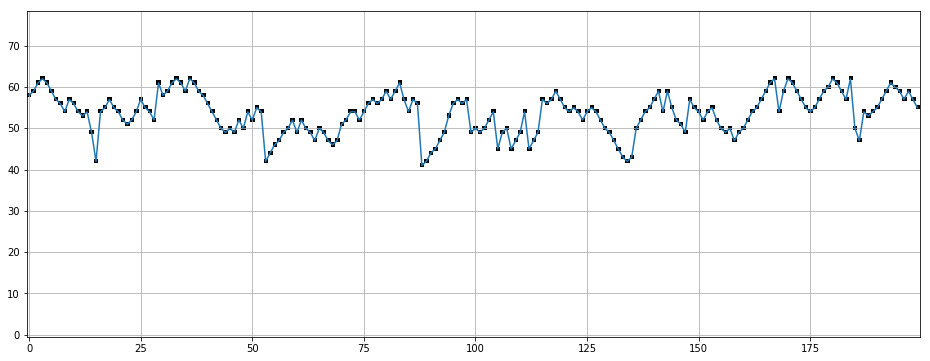

In [292]:
print(note_l)

plt.figure(figsize=(16, 6))
plt.imshow(np.asarray(prediction_l)[:].T, aspect='auto', origin='lower')
plt.plot(note_l)
plt.set_cmap('gray_r')
plt.grid(True)



### Create a MIDI file and an audio file which correspond to the generated sequence

Once the new sequence has been generated (```note_l```) we transform it to a new MIDI file and perform (a very cheap) rendering of it in an audio file.

In [293]:
new_midi_data = pretty_midi.PrettyMIDI()
cello_program = pretty_midi.instrument_name_to_program('Cello')
cello = pretty_midi.Instrument(program=cello_program)
time = 0
step = 0.3
for note_number in note_l:
    myNote = pretty_midi.Note(velocity=100, pitch=note_number, start=time, end=time+step)
    cello.notes.append(myNote)
    time += step
new_midi_data.instruments.append(cello)

In [294]:
%matplotlib inline

audio_data = new_midi_data.synthesize()
IPython.display.Audio(audio_data, rate=44100)

# Evaluation

To evaluate the work, you should rate the code for 
- 1) Data conversion for the training of language model (01)
- 2) Training the language model (02)
- 3) Generating a new sequence from sampling the language model (03)

You will also rate the answer to the four questions below.

## Question 1)

Que se passe-t'il si on remplace la cellule LSTM par une cellule RNNsimple ?

**Réponse (en-dessous)** (1 points)

#### Si nous remplaçons les LSTM par des RNN simple, nous perdrons la capacité de mémoire et donc la possibilité de produire une mélodie faisant référence à des notes passées plus eloignées. 

## Question 2) 

Que se passe-t'il si l'on raccourci la longueur des séquences utilisées pour l'entrainement ? Comment palier à cet effet ?

**Réponse (en-dessous)** (1 points)

#### L'apprentissage est alors moins performant (underfitiing) car il y a moins d'information disponible dans chaque séquence d'entrainement mais il y a également plus de séquences.

#### Afin de capter les mélodies alors moins détectables, on peut augmenter la complexité du modele (ajout de couches) 

## Question 3) 
Comment pourrait-on rendre le système ```polyphonique``` (plusieurs notes jouées simultanément par le même instrument) ? pour l'entrainement ? pour la génération ?

**Réponse (en-dessous)** (2 points)

#### Dans un premier temps, il faut définir le degré de polyphonie n_p. Ensuite, par la suite, au lieu d'encoder en one hot sur 79, on encode sur 79 * n_p. Les 79 premieres valeurs encode la premiere note (One hot), les 79 suivantes encode la note polyphonique de degré 2 (One hot) et ainsi de suite jusqu'au degré n_p. 

#### De meme pour la note prédite, on encode en sortie sur 79 * n_p.

#### Si le degré polyphoniqueest élevé, on peut travailler avec les indexes non nuls pour éviter les problemes de dimension.

## Question 4) 

Nous avons utilisé une procédure simplifiée pour entrainer le modèle de language musical, en transformant l'apprentissage en un problème Many-To-one. Expliquez ? Comment entraine-t'on habituellement un modèle de language avec un RNN ? Quel en serait l'avantage ?

**Réponse (en-dessous)** (2 points)

#### Ici, au lieu de prédire une séquence compléte d'un coup, on prédit les notes une à une à partir d'une séquence de taille fixe (many to one) puis en décalant la séquence à chaque prédiction.

#### Habituellement ce probleme est reglé en many to many, c'est à dire qu'on prend en entré une séquence de taille fixe et qu'on l'utilise pour predire une autre séqunce de taille fixe. Généralement, la séquence d'entrainement est plus longue que la séquence prédite. L'avantage de cette méthode est qu'avec la propriété mémoire des LSTM on peut capter plus efficacement la mélodie afin d'en retranscrire une sembleble. En prédisant les notes une à une et en utilisant les notes prédites successivement pour déterminer les notes suivantes, on perd de l'information sur la mélodie, de fait le morceau généré par le modele est moins pertinant pour l'apprentissage. 